### TFG - Cesar Hernandez Rodriguez
Segundos pasos en las redes neuronales y la bolsa, para este caso buscamos predecir valores y no tendencias

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice nasdaq que es uno de los índices más importantes de Estados Unidos, siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. 

El primer paso será mediante WEB-Scrapping descargar de Wikipedia los tickets de los 500 valores del índice bursatil, después ire recursivamente descargando todos los datos disponibles de los 500 valores desde el 2000 hasta el final del año 2017, estos datos los usare para entrenar la red neuronal y poder predecir el primer trimestre de 2018. La selección de estas fechas se debe al a disponibilidad que ofrece la librería Quandl ya que al usarla de forma gratuita no se puede descargar los históricos de todos los datos ni todo los datos más actuales, de todas formas aún asi vamos a tener problemas ya que solo he conseguido de 485 de 500 activos y de algunos no tenemos unos datos históricos tan extensos como lo que buscabamos.

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

In [1]:
# Import predefinifods
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt
from collections import Counter

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
import keras.backend as K

# Conteo
from collections import Counter

Using TensorFlow backend.


In [2]:
#Tengo dos bases de datos con todos los tickers del indice nasdaq y todos los tickers
# que tiene mi base de datos y extraigo solo los que tengo
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-listed-symbols.csv')['Symbol']
    
    tickersQuandl = []    
    tickers = []
    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq[i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers.append(word)
    # Con el k seleccionas cuantos activos quieres
    tickers = random.choices(tickers, k=15)
    
    for tick in tickers:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

# a,b = get_tickers_sample_nasdaq()

In [4]:
# Descargo los datos de la API Quandl, para ello uso el conjunto de datos que me ofrece WIKI/ que se puede ver
# en la página de la libreria y me registro en la pagina de forma gratuita dandome una key.
# me devuelve una lista con todos los datos posibles de ese activo, yo guardo todos y por separado los de cierre
# Aunque solo me interese los de cierre quiero guardar todos los datos por si en una extension de este trabajo se queire 
# usar cualquier otro dato
# Para no tener que realizar la parte de descarga cada vez que se inicia el programa se ha habilitado la descarga
# y guardado de datos en una carpeta datos que ya debe crearse antes. Los datos se guardan serializados.

def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        #aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        aux=quandl.get(ticker,start_date="2010-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2016-10-30",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
    # Solo cogemos los datos que nos da la aplicacion
    # ya que hay activos que no tenemos su valor en esas fechas o tenemos muy pocos datos

    quitar = []
    for key in tickers:
        if datosClose_test[key].empty:
            if verbose == True : print("Restriccion de vacio",key) 
            datos.pop(key,None)
            datosClose.pop(key,None)
            datos_test.pop(key,None)
            datosClose_test.pop(key,None)
            quitar.append(key)
        elif len(datosClose_test[key]) < 300:
            if verbose == True :  print("Restriccion de longitud",key)
            datos.pop(key,None)
            datosClose.pop(key,None)
            datos_test.pop(key,None)
            datosClose_test.pop(key,None)
            quitar.append(key)
            
    for key in quitar:
        tickers.remove(key)
    
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos/nasdaq_test.p", "wb"))
    pickle.dump(datosClose_test, open("datos/nasdaqClose_test.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [5]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos/nasdaq_test.p", "rb" ))
    datosClose_test = pickle.load(open("datos/nasdaqClose_test.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre].plot(figsize=(12,5),grid=True)
    plt.title('{} {}\n'.format(nombre,test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [6]:
datos_descargados = False
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a descargar los datos****

LLeva descargados el  0.0 % de los datos
LLeva descargados el  13.333333333333334 % de los datos
LLeva descargados el  26.666666666666668 % de los datos
LLeva descargados el  40.0 % de los datos
LLeva descargados el  53.333333333333336 % de los datos
LLeva descargados el  66.66666666666666 % de los datos
LLeva descargados el  80.0 % de los datos
LLeva descargados el  93.33333333333333 % de los datos

Ha tardado en descargar los datos: 25.1109755039 segundos.

 ****Empezamos a descargar los datos test****

LLeva descargados el  0.0 % de los datos test
LLeva descargados el  13.333333333333334 % de los datos test
LLeva descargados el  26.666666666666668 % de los datos test
LLeva descargados el  40.0 % de los datos test
LLeva descargados el  53.333333333333336 % de los datos test
LLeva descargados el  66.66666666666666 % de los datos test
LLeva descargados el  80.0 % de los datos test
LLeva descargados el  93.33333333333333 % de los datos test

Ha 

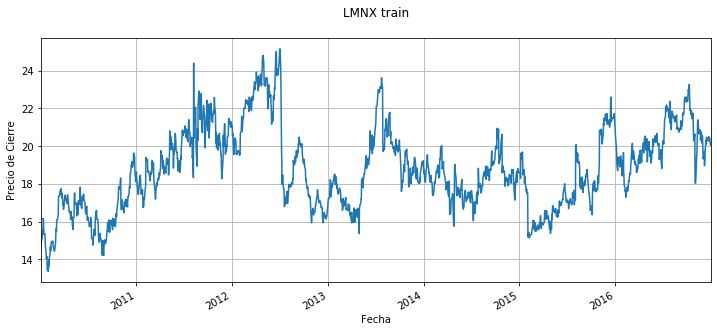

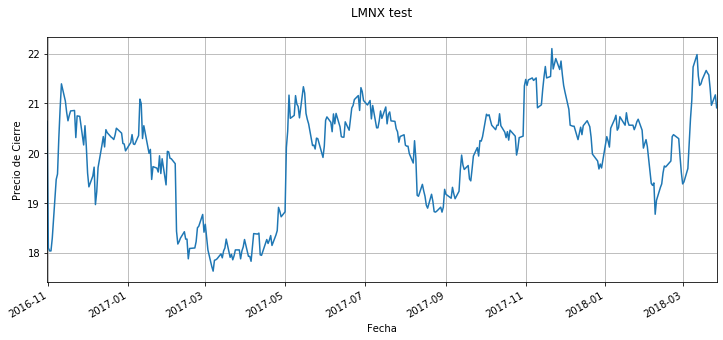

In [7]:
# Grafico un activo aleatorio que luego predecire
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = random.randint(0,len(tickers)-1)
plot_datos(datosClose,tickers[ran],"train")
plot_datos(datosClose_test,tickers[ran],"test")

In [8]:
# Para crear los atributos que voy a meter en la red Neuronal uso esta funcion, mis atributos son
# Dos medias moviles, una de 30 dias y otra de 15 para hacer la simulacion con los datos de un mes y la mitad de mes
# por ulitmo creo un oscilador de la media movil de 30 dias donde resto los valores son separacion de 30 dias
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

    


In [9]:
# A parte de la creacion de atributos
index = ran
timeStep = 21 # longitud de secuencias que se hacen en cada iteracion de la red

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers[index]],10,20)
Y = pd.DataFrame(datosClose[tickers[index]].values[21:len(datosClose[tickers[index]])])
X = X.to_numpy()

# Creamos los atributos para los datos test
ticket_uso = tickers[index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers[index]],10,20)
Ytesteo = pd.DataFrame(datosClose_test[tickers[index]].values[21:len(datosClose_test[tickers[index]])])
Xtesteo = Xtesteo.to_numpy()

X_aux = np.concatenate((X,Xtesteo),axis=0)

scaler = MinMaxScaler()
X_aux_scaled = scaler.fit_transform(X_aux)
X_scaled = X_aux_scaled[0:len(X)]
Xtesteo_scaled = X_aux_scaled[len(X):len(X_aux_scaled)]

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


print("Voy a predecir el activo ",ticket_uso)

Voy a predecir el activo  LMNX


In [11]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

In [13]:
# Creacion de la red neural LSTM

model = Sequential()
model.add(LSTM(4, input_shape=(21,3),return_sequences=True))
model.add(LSTM(units = 2,return_sequences = False))
model.add(Dense(1)) 
model.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 21, 4)             128       
_________________________________________________________________
lstm_4 (LSTM)                (None, 2)                 56        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________


In [14]:
history_LSTM = model.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Train on 1146 samples, validate on 574 samples
Epoch 1/1500
1146/1146 [==============================] - 3s 2ms/step - loss: 353.3266 - porcentaje_margen: 0.0000e+00 - val_loss: 352.8128 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 342.8296 - porcentaje_margen: 0.0000e+00 - val_loss: 338.4377 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 326.0597 - porcentaje_margen: 0.0000e+00 - val_loss: 322.2866 - val_porcentaje_margen: 0.0000e+00
Epoch 4/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 313.6276 - porcentaje_margen: 0.0000e+00 - val_loss: 312.2336 - val_porcentaje_margen: 0.0000e+00
Epoch 5/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 303.9454 - porcentaje_margen: 0.0000e+00 - val_loss: 302.7098 - val_porcentaje_margen: 0.0000e+00
Epoch 6/1500
1146/1146 [==============================] - 1s 1ms/step - l

1146/1146 [==============================] - 1s 998us/step - loss: 154.2208 - porcentaje_margen: 0.0000e+00 - val_loss: 155.6210 - val_porcentaje_margen: 0.0000e+00
Epoch 48/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 151.8603 - porcentaje_margen: 0.0000e+00 - val_loss: 153.2522 - val_porcentaje_margen: 0.0000e+00
Epoch 49/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 149.5237 - porcentaje_margen: 0.0000e+00 - val_loss: 150.9151 - val_porcentaje_margen: 0.0000e+00
Epoch 50/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 147.2168 - porcentaje_margen: 0.0000e+00 - val_loss: 148.5980 - val_porcentaje_margen: 0.0000e+00
Epoch 51/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 144.9352 - porcentaje_margen: 0.0000e+00 - val_loss: 146.3063 - val_porcentaje_margen: 0.0000e+00
Epoch 52/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 142.6773 - porcentaje_margen: 0.0000e+00 - val_l

1146/1146 [==============================] - 1s 1ms/step - loss: 69.7170 - porcentaje_margen: 0.0000e+00 - val_loss: 70.8095 - val_porcentaje_margen: 0.0000e+00
Epoch 94/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 68.3640 - porcentaje_margen: 0.0000e+00 - val_loss: 69.4465 - val_porcentaje_margen: 0.0000e+00
Epoch 95/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 67.0275 - porcentaje_margen: 0.0000e+00 - val_loss: 68.1019 - val_porcentaje_margen: 0.0000e+00
Epoch 96/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 65.7088 - porcentaje_margen: 0.0000e+00 - val_loss: 66.7763 - val_porcentaje_margen: 0.0000e+00
Epoch 97/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 64.4089 - porcentaje_margen: 0.0000e+00 - val_loss: 65.4681 - val_porcentaje_margen: 0.0000e+00
Epoch 98/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 63.1265 - porcentaje_margen: 0.0000e+00 - val_loss: 64.1797 

1146/1146 [==============================] - 1s 1ms/step - loss: 23.9799 - porcentaje_margen: 0.0165 - val_loss: 24.7199 - val_porcentaje_margen: 0.0123
Epoch 141/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 23.3621 - porcentaje_margen: 0.0174 - val_loss: 24.0971 - val_porcentaje_margen: 0.0123
Epoch 142/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 22.7586 - porcentaje_margen: 0.0208 - val_loss: 23.4853 - val_porcentaje_margen: 0.0175
Epoch 143/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 22.1682 - porcentaje_margen: 0.0236 - val_loss: 22.8863 - val_porcentaje_margen: 0.0209
Epoch 144/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 21.5900 - porcentaje_margen: 0.0254 - val_loss: 22.3017 - val_porcentaje_margen: 0.0262
Epoch 145/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 21.0249 - porcentaje_margen: 0.0280 - val_loss: 21.7297 - val_porcentaje_margen: 0.0279
Epoch 1

1146/1146 [==============================] - 1s 1ms/step - loss: 6.6731 - porcentaje_margen: 0.3141 - val_loss: 7.0860 - val_porcentaje_margen: 0.2792
Epoch 190/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 6.5359 - porcentaje_margen: 0.3174 - val_loss: 6.9425 - val_porcentaje_margen: 0.2757
Epoch 191/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 6.4044 - porcentaje_margen: 0.3219 - val_loss: 6.8054 - val_porcentaje_margen: 0.2810
Epoch 192/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 6.2800 - porcentaje_margen: 0.3269 - val_loss: 6.6709 - val_porcentaje_margen: 0.2863
Epoch 193/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 6.1579 - porcentaje_margen: 0.3247 - val_loss: 6.5510 - val_porcentaje_margen: 0.2863
Epoch 194/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 6.0458 - porcentaje_margen: 0.3228 - val_loss: 6.4283 - val_porcentaje_margen: 0.2811
Epoch 195/1500
1146

1146/1146 [==============================] - 1s 1ms/step - loss: 4.3119 - porcentaje_margen: 0.3257 - val_loss: 4.5235 - val_porcentaje_margen: 0.3067
Epoch 239/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 4.3084 - porcentaje_margen: 0.3286 - val_loss: 4.5185 - val_porcentaje_margen: 0.3119
Epoch 240/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 4.3054 - porcentaje_margen: 0.3306 - val_loss: 4.5119 - val_porcentaje_margen: 0.3102
Epoch 241/1500
1146/1146 [==============================] - 1s 978us/step - loss: 4.3022 - porcentaje_margen: 0.3289 - val_loss: 4.5073 - val_porcentaje_margen: 0.3119
Epoch 242/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 4.2994 - porcentaje_margen: 0.3271 - val_loss: 4.5035 - val_porcentaje_margen: 0.3137
Epoch 243/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 4.2971 - porcentaje_margen: 0.3269 - val_loss: 4.4998 - val_porcentaje_margen: 0.3119
Epoch 244/1500
11

1146/1146 [==============================] - 1s 1ms/step - loss: 4.2821 - porcentaje_margen: 0.3284 - val_loss: 4.4618 - val_porcentaje_margen: 0.2998
Epoch 288/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 4.2820 - porcentaje_margen: 0.3308 - val_loss: 4.4622 - val_porcentaje_margen: 0.3015
Epoch 289/1500
1146/1146 [==============================] - 1s 984us/step - loss: 4.2820 - porcentaje_margen: 0.3304 - val_loss: 4.4621 - val_porcentaje_margen: 0.3015
Epoch 290/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 4.2821 - porcentaje_margen: 0.3300 - val_loss: 4.4623 - val_porcentaje_margen: 0.3015
Epoch 291/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 4.2820 - porcentaje_margen: 0.3308 - val_loss: 4.4623 - val_porcentaje_margen: 0.3015
Epoch 292/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 4.2825 - porcentaje_margen: 0.3287 - val_loss: 4.4612 - val_porcentaje_margen: 0.3015
Epoch 293/1500
11

1146/1146 [==============================] - 1s 1ms/step - loss: 4.2824 - porcentaje_margen: 0.3302 - val_loss: 4.4625 - val_porcentaje_margen: 0.3015
Epoch 337/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 4.2822 - porcentaje_margen: 0.3295 - val_loss: 4.4614 - val_porcentaje_margen: 0.2998
Epoch 338/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 4.2821 - porcentaje_margen: 0.3276 - val_loss: 4.4615 - val_porcentaje_margen: 0.2998
Epoch 339/1500
1146/1146 [==============================] - 1s 991us/step - loss: 4.2821 - porcentaje_margen: 0.3299 - val_loss: 4.4620 - val_porcentaje_margen: 0.3015
Epoch 340/1500
1146/1146 [==============================] - 1s 997us/step - loss: 4.2819 - porcentaje_margen: 0.3308 - val_loss: 4.4620 - val_porcentaje_margen: 0.3015
Epoch 341/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 4.2818 - porcentaje_margen: 0.3306 - val_loss: 4.4615 - val_porcentaje_margen: 0.3015
Epoch 342/1500


1146/1146 [==============================] - 1s 1ms/step - loss: 0.8042 - porcentaje_margen: 0.7559 - val_loss: 0.9558 - val_porcentaje_margen: 0.7348
Epoch 386/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.7987 - porcentaje_margen: 0.7631 - val_loss: 0.9721 - val_porcentaje_margen: 0.7352
Epoch 387/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.7933 - porcentaje_margen: 0.7566 - val_loss: 0.9309 - val_porcentaje_margen: 0.7384
Epoch 388/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.7744 - porcentaje_margen: 0.7726 - val_loss: 0.9521 - val_porcentaje_margen: 0.7334
Epoch 389/1500
1146/1146 [==============================] - 1s 978us/step - loss: 0.7707 - porcentaje_margen: 0.7709 - val_loss: 0.9172 - val_porcentaje_margen: 0.7436
Epoch 390/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.7548 - porcentaje_margen: 0.7766 - val_loss: 0.9010 - val_porcentaje_margen: 0.7471
Epoch 391/1500
11

1146/1146 [==============================] - 1s 1ms/step - loss: 0.5816 - porcentaje_margen: 0.8197 - val_loss: 0.8353 - val_porcentaje_margen: 0.7801
Epoch 435/1500
1146/1146 [==============================] - 1s 995us/step - loss: 0.5816 - porcentaje_margen: 0.8182 - val_loss: 0.7341 - val_porcentaje_margen: 0.8101
Epoch 436/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.5705 - porcentaje_margen: 0.8297 - val_loss: 0.7215 - val_porcentaje_margen: 0.8101
Epoch 437/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.5640 - porcentaje_margen: 0.8284 - val_loss: 0.7291 - val_porcentaje_margen: 0.8132
Epoch 438/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.5657 - porcentaje_margen: 0.8336 - val_loss: 0.7292 - val_porcentaje_margen: 0.8079
Epoch 439/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.5753 - porcentaje_margen: 0.8237 - val_loss: 0.7254 - val_porcentaje_margen: 0.8115
Epoch 440/1500
11

1146/1146 [==============================] - 1s 1ms/step - loss: 0.4933 - porcentaje_margen: 0.8719 - val_loss: 0.6454 - val_porcentaje_margen: 0.8186
Epoch 484/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.5057 - porcentaje_margen: 0.8687 - val_loss: 0.6199 - val_porcentaje_margen: 0.8535
Epoch 485/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.5049 - porcentaje_margen: 0.8773 - val_loss: 0.6171 - val_porcentaje_margen: 0.8500
Epoch 486/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.5005 - porcentaje_margen: 0.8657 - val_loss: 0.6354 - val_porcentaje_margen: 0.8535
Epoch 487/1500
1146/1146 [==============================] - 1s 993us/step - loss: 0.4920 - porcentaje_margen: 0.8771 - val_loss: 0.6115 - val_porcentaje_margen: 0.8500
Epoch 488/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4888 - porcentaje_margen: 0.8841 - val_loss: 0.6107 - val_porcentaje_margen: 0.8464
Epoch 489/1500
11

1146/1146 [==============================] - 1s 1ms/step - loss: 0.4738 - porcentaje_margen: 0.8913 - val_loss: 0.5516 - val_porcentaje_margen: 0.8779
Epoch 533/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4548 - porcentaje_margen: 0.8874 - val_loss: 0.5486 - val_porcentaje_margen: 0.8676
Epoch 534/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4666 - porcentaje_margen: 0.8817 - val_loss: 0.5573 - val_porcentaje_margen: 0.8762
Epoch 535/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4616 - porcentaje_margen: 0.8789 - val_loss: 0.5405 - val_porcentaje_margen: 0.8711
Epoch 536/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4501 - porcentaje_margen: 0.8970 - val_loss: 0.5412 - val_porcentaje_margen: 0.8623
Epoch 537/1500
1146/1146 [==============================] - ETA: 0s - loss: 0.4598 - porcentaje_margen: 0.887 - 1s 1ms/step - loss: 0.4541 - porcentaje_margen: 0.8896 - val_loss: 0.5483

1146/1146 [==============================] - 1s 1ms/step - loss: 0.4502 - porcentaje_margen: 0.8892 - val_loss: 0.5071 - val_porcentaje_margen: 0.8867
Epoch 582/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4685 - porcentaje_margen: 0.8846 - val_loss: 0.5863 - val_porcentaje_margen: 0.8185
Epoch 583/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4495 - porcentaje_margen: 0.8841 - val_loss: 0.5043 - val_porcentaje_margen: 0.8884
Epoch 584/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4429 - porcentaje_margen: 0.8990 - val_loss: 0.5259 - val_porcentaje_margen: 0.8815
Epoch 585/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4691 - porcentaje_margen: 0.8920 - val_loss: 0.5082 - val_porcentaje_margen: 0.8814
Epoch 586/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4552 - porcentaje_margen: 0.8801 - val_loss: 0.5066 - val_porcentaje_margen: 0.8867
Epoch 587/1500
1146

1146/1146 [==============================] - 1s 1ms/step - loss: 0.4395 - porcentaje_margen: 0.8935 - val_loss: 0.5186 - val_porcentaje_margen: 0.8481
Epoch 631/1500
1146/1146 [==============================] - 1s 969us/step - loss: 0.4326 - porcentaje_margen: 0.8984 - val_loss: 0.4736 - val_porcentaje_margen: 0.8867
Epoch 632/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4332 - porcentaje_margen: 0.8946 - val_loss: 0.4764 - val_porcentaje_margen: 0.8900
Epoch 633/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4324 - porcentaje_margen: 0.8922 - val_loss: 0.4780 - val_porcentaje_margen: 0.8919
Epoch 634/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4287 - porcentaje_margen: 0.8987 - val_loss: 0.4701 - val_porcentaje_margen: 0.8936
Epoch 635/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4278 - porcentaje_margen: 0.8959 - val_loss: 0.4777 - val_porcentaje_margen: 0.8883
Epoch 636/1500
11

1146/1146 [==============================] - 1s 990us/step - loss: 0.4215 - porcentaje_margen: 0.8946 - val_loss: 0.4807 - val_porcentaje_margen: 0.8656
Epoch 680/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4355 - porcentaje_margen: 0.8961 - val_loss: 0.4544 - val_porcentaje_margen: 0.8970
Epoch 681/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4205 - porcentaje_margen: 0.8968 - val_loss: 0.4608 - val_porcentaje_margen: 0.8953
Epoch 682/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4304 - porcentaje_margen: 0.8928 - val_loss: 0.4566 - val_porcentaje_margen: 0.8987
Epoch 683/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4255 - porcentaje_margen: 0.8944 - val_loss: 0.4775 - val_porcentaje_margen: 0.8884
Epoch 684/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4256 - porcentaje_margen: 0.8883 - val_loss: 0.4694 - val_porcentaje_margen: 0.8796
Epoch 685/1500
11

1146/1146 [==============================] - 1s 1ms/step - loss: 0.4153 - porcentaje_margen: 0.9006 - val_loss: 0.4447 - val_porcentaje_margen: 0.8970
Epoch 729/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4204 - porcentaje_margen: 0.8956 - val_loss: 0.4492 - val_porcentaje_margen: 0.8936
Epoch 730/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4313 - porcentaje_margen: 0.8879 - val_loss: 0.4573 - val_porcentaje_margen: 0.8726
Epoch 731/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4154 - porcentaje_margen: 0.8957 - val_loss: 0.4445 - val_porcentaje_margen: 0.9005
Epoch 732/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4177 - porcentaje_margen: 0.8965 - val_loss: 0.4589 - val_porcentaje_margen: 0.8848
Epoch 733/1500
1146/1146 [==============================] - 1s 987us/step - loss: 0.4307 - porcentaje_margen: 0.8896 - val_loss: 0.4403 - val_porcentaje_margen: 0.8988
Epoch 734/1500
11

1146/1146 [==============================] - 1s 952us/step - loss: 0.4315 - porcentaje_margen: 0.8911 - val_loss: 0.4357 - val_porcentaje_margen: 0.9005
Epoch 778/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4087 - porcentaje_margen: 0.8954 - val_loss: 0.4440 - val_porcentaje_margen: 0.8883
Epoch 779/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4114 - porcentaje_margen: 0.8985 - val_loss: 0.4526 - val_porcentaje_margen: 0.8741
Epoch 780/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4261 - porcentaje_margen: 0.8885 - val_loss: 0.4540 - val_porcentaje_margen: 0.8830
Epoch 781/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4155 - porcentaje_margen: 0.8857 - val_loss: 0.4804 - val_porcentaje_margen: 0.8481
Epoch 782/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4159 - porcentaje_margen: 0.8939 - val_loss: 0.4356 - val_porcentaje_margen: 0.8987
Epoch 783/1500
11

1146/1146 [==============================] - 1s 1ms/step - loss: 0.4028 - porcentaje_margen: 0.8950 - val_loss: 0.4196 - val_porcentaje_margen: 0.9006
Epoch 827/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4109 - porcentaje_margen: 0.8868 - val_loss: 0.4214 - val_porcentaje_margen: 0.9005
Epoch 828/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4081 - porcentaje_margen: 0.8902 - val_loss: 0.4227 - val_porcentaje_margen: 0.8899
Epoch 829/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4056 - porcentaje_margen: 0.8870 - val_loss: 0.4209 - val_porcentaje_margen: 0.8953
Epoch 830/1500
1146/1146 [==============================] - 1s 949us/step - loss: 0.4018 - porcentaje_margen: 0.8942 - val_loss: 0.4188 - val_porcentaje_margen: 0.9005
Epoch 831/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4029 - porcentaje_margen: 0.9006 - val_loss: 0.4208 - val_porcentaje_margen: 0.9022
Epoch 832/1500
11

1146/1146 [==============================] - 1s 1ms/step - loss: 0.3994 - porcentaje_margen: 0.8913 - val_loss: 0.4205 - val_porcentaje_margen: 0.8971
Epoch 876/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3989 - porcentaje_margen: 0.8948 - val_loss: 0.4111 - val_porcentaje_margen: 0.8988
Epoch 877/1500
1146/1146 [==============================] - 1s 998us/step - loss: 0.3936 - porcentaje_margen: 0.8991 - val_loss: 0.4096 - val_porcentaje_margen: 0.8954
Epoch 878/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4008 - porcentaje_margen: 0.8931 - val_loss: 0.4147 - val_porcentaje_margen: 0.8971
Epoch 879/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3991 - porcentaje_margen: 0.8956 - val_loss: 0.4068 - val_porcentaje_margen: 0.9006
Epoch 880/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3942 - porcentaje_margen: 0.8985 - val_loss: 0.4195 - val_porcentaje_margen: 0.8847
Epoch 881/1500
11

1146/1146 [==============================] - 1s 1ms/step - loss: 0.3882 - porcentaje_margen: 0.8976 - val_loss: 0.4017 - val_porcentaje_margen: 0.8972
Epoch 925/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3913 - porcentaje_margen: 0.8989 - val_loss: 0.4063 - val_porcentaje_margen: 0.8972
Epoch 926/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3939 - porcentaje_margen: 0.8932 - val_loss: 0.4016 - val_porcentaje_margen: 0.8972
Epoch 927/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3905 - porcentaje_margen: 0.8989 - val_loss: 0.4259 - val_porcentaje_margen: 0.8759
Epoch 928/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3943 - porcentaje_margen: 0.8920 - val_loss: 0.4025 - val_porcentaje_margen: 0.8972
Epoch 929/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3901 - porcentaje_margen: 0.8952 - val_loss: 0.4012 - val_porcentaje_margen: 0.8937
Epoch 930/1500
1146

Epoch 973/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3913 - porcentaje_margen: 0.8940 - val_loss: 0.3998 - val_porcentaje_margen: 0.8937
Epoch 974/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3831 - porcentaje_margen: 0.8954 - val_loss: 0.4074 - val_porcentaje_margen: 0.8832
Epoch 975/1500
1146/1146 [==============================] - 1s 999us/step - loss: 0.3964 - porcentaje_margen: 0.8928 - val_loss: 0.4029 - val_porcentaje_margen: 0.8815
Epoch 976/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3868 - porcentaje_margen: 0.8954 - val_loss: 0.3999 - val_porcentaje_margen: 0.8955
Epoch 977/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3846 - porcentaje_margen: 0.8915 - val_loss: 0.3996 - val_porcentaje_margen: 0.9007
Epoch 978/1500
1146/1146 [==============================] - 1s 991us/step - loss: 0.3981 - porcentaje_margen: 0.8900 - val_loss: 0.4242 - val_porcentaje_margen: 0.8955


Epoch 1022/1500
1146/1146 [==============================] - 1s 921us/step - loss: 0.3835 - porcentaje_margen: 0.8985 - val_loss: 0.4016 - val_porcentaje_margen: 0.8937
Epoch 1023/1500
1146/1146 [==============================] - 1s 971us/step - loss: 0.3847 - porcentaje_margen: 0.8963 - val_loss: 0.3967 - val_porcentaje_margen: 0.8937
Epoch 1024/1500
1146/1146 [==============================] - 1s 926us/step - loss: 0.3778 - porcentaje_margen: 0.8922 - val_loss: 0.3990 - val_porcentaje_margen: 0.8902
Epoch 1025/1500
1146/1146 [==============================] - 1s 926us/step - loss: 0.3818 - porcentaje_margen: 0.8968 - val_loss: 0.4020 - val_porcentaje_margen: 0.8955
Epoch 1026/1500
1146/1146 [==============================] - 1s 977us/step - loss: 0.3868 - porcentaje_margen: 0.8980 - val_loss: 0.4092 - val_porcentaje_margen: 0.8867
Epoch 1027/1500
1146/1146 [==============================] - 1s 915us/step - loss: 0.3837 - porcentaje_margen: 0.8940 - val_loss: 0.3964 - val_porcentaje_m

1146/1146 [==============================] - 1s 931us/step - loss: 0.3768 - porcentaje_margen: 0.9017 - val_loss: 0.3932 - val_porcentaje_margen: 0.8920
Epoch 1071/1500
1146/1146 [==============================] - 1s 968us/step - loss: 0.3834 - porcentaje_margen: 0.8961 - val_loss: 0.4215 - val_porcentaje_margen: 0.8726
Epoch 1072/1500
1146/1146 [==============================] - 1s 954us/step - loss: 0.3794 - porcentaje_margen: 0.8942 - val_loss: 0.3978 - val_porcentaje_margen: 0.8972
Epoch 1073/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3794 - porcentaje_margen: 0.8965 - val_loss: 0.3982 - val_porcentaje_margen: 0.8936
Epoch 1074/1500
1146/1146 [==============================] - 1s 921us/step - loss: 0.3756 - porcentaje_margen: 0.9013 - val_loss: 0.4039 - val_porcentaje_margen: 0.8955
Epoch 1075/1500
1146/1146 [==============================] - 1s 953us/step - loss: 0.3927 - porcentaje_margen: 0.8928 - val_loss: 0.4389 - val_porcentaje_margen: 0.8885
Epoc

1146/1146 [==============================] - 1s 965us/step - loss: 0.3752 - porcentaje_margen: 0.8962 - val_loss: 0.4005 - val_porcentaje_margen: 0.8935
Epoch 1119/1500
1146/1146 [==============================] - 1s 965us/step - loss: 0.3751 - porcentaje_margen: 0.8958 - val_loss: 0.4018 - val_porcentaje_margen: 0.8918
Epoch 1120/1500
1146/1146 [==============================] - 1s 910us/step - loss: 0.3765 - porcentaje_margen: 0.8978 - val_loss: 0.3989 - val_porcentaje_margen: 0.8955
Epoch 1121/1500
1146/1146 [==============================] - 1s 973us/step - loss: 0.3826 - porcentaje_margen: 0.8922 - val_loss: 0.3999 - val_porcentaje_margen: 0.8954
Epoch 1122/1500
1146/1146 [==============================] - 1s 914us/step - loss: 0.3740 - porcentaje_margen: 0.8987 - val_loss: 0.3980 - val_porcentaje_margen: 0.8918
Epoch 1123/1500
1146/1146 [==============================] - 1s 965us/step - loss: 0.3798 - porcentaje_margen: 0.8970 - val_loss: 0.3919 - val_porcentaje_margen: 0.8955
Ep

Epoch 1167/1500
1146/1146 [==============================] - 1s 938us/step - loss: 0.3682 - porcentaje_margen: 0.9000 - val_loss: 0.3850 - val_porcentaje_margen: 0.9042
Epoch 1168/1500
1146/1146 [==============================] - 1s 964us/step - loss: 0.3751 - porcentaje_margen: 0.8996 - val_loss: 0.3875 - val_porcentaje_margen: 0.8954
Epoch 1169/1500
1146/1146 [==============================] - 1s 940us/step - loss: 0.3719 - porcentaje_margen: 0.9026 - val_loss: 0.3877 - val_porcentaje_margen: 0.9006
Epoch 1170/1500
1146/1146 [==============================] - 1s 951us/step - loss: 0.3698 - porcentaje_margen: 0.8994 - val_loss: 0.3855 - val_porcentaje_margen: 0.8972
Epoch 1171/1500
1146/1146 [==============================] - 1s 988us/step - loss: 0.3697 - porcentaje_margen: 0.8958 - val_loss: 0.3886 - val_porcentaje_margen: 0.8971
Epoch 1172/1500
1146/1146 [==============================] - 1s 943us/step - loss: 0.3700 - porcentaje_margen: 0.9022 - val_loss: 0.3858 - val_porcentaje_m

1146/1146 [==============================] - 1s 961us/step - loss: 0.3656 - porcentaje_margen: 0.9002 - val_loss: 0.3862 - val_porcentaje_margen: 0.8971
Epoch 1216/1500
1146/1146 [==============================] - 1s 968us/step - loss: 0.3670 - porcentaje_margen: 0.9004 - val_loss: 0.3990 - val_porcentaje_margen: 0.9042
Epoch 1217/1500
1146/1146 [==============================] - 1s 926us/step - loss: 0.3664 - porcentaje_margen: 0.8992 - val_loss: 0.3906 - val_porcentaje_margen: 0.9059
Epoch 1218/1500
1146/1146 [==============================] - 1s 944us/step - loss: 0.3676 - porcentaje_margen: 0.9020 - val_loss: 0.3836 - val_porcentaje_margen: 0.9007
Epoch 1219/1500
1146/1146 [==============================] - 1s 932us/step - loss: 0.3726 - porcentaje_margen: 0.8972 - val_loss: 0.4003 - val_porcentaje_margen: 0.8990
Epoch 1220/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3661 - porcentaje_margen: 0.9026 - val_loss: 0.3846 - val_porcentaje_margen: 0.9024
Epoc

Epoch 1264/1500
1146/1146 [==============================] - 1s 974us/step - loss: 0.3751 - porcentaje_margen: 0.8930 - val_loss: 0.4016 - val_porcentaje_margen: 0.9024
Epoch 1265/1500
1146/1146 [==============================] - 1s 960us/step - loss: 0.3704 - porcentaje_margen: 0.9008 - val_loss: 0.3850 - val_porcentaje_margen: 0.8990
Epoch 1266/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3767 - porcentaje_margen: 0.8933 - val_loss: 0.3958 - val_porcentaje_margen: 0.8953
Epoch 1267/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3866 - porcentaje_margen: 0.8888 - val_loss: 0.4006 - val_porcentaje_margen: 0.8848
Epoch 1268/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3630 - porcentaje_margen: 0.9020 - val_loss: 0.3949 - val_porcentaje_margen: 0.8990
Epoch 1269/1500
1146/1146 [==============================] - 1s 984us/step - loss: 0.3703 - porcentaje_margen: 0.8964 - val_loss: 0.3835 - val_porcentaje_margen:

1146/1146 [==============================] - 1s 966us/step - loss: 0.3643 - porcentaje_margen: 0.9004 - val_loss: 0.3856 - val_porcentaje_margen: 0.8936
Epoch 1313/1500
1146/1146 [==============================] - 1s 999us/step - loss: 0.3627 - porcentaje_margen: 0.9050 - val_loss: 0.3815 - val_porcentaje_margen: 0.9024
Epoch 1314/1500
1146/1146 [==============================] - 1s 896us/step - loss: 0.3617 - porcentaje_margen: 0.9060 - val_loss: 0.3890 - val_porcentaje_margen: 0.8919
Epoch 1315/1500
1146/1146 [==============================] - 1s 981us/step - loss: 0.3670 - porcentaje_margen: 0.8920 - val_loss: 0.3989 - val_porcentaje_margen: 0.8900
Epoch 1316/1500
1146/1146 [==============================] - 1s 899us/step - loss: 0.3635 - porcentaje_margen: 0.8982 - val_loss: 0.3821 - val_porcentaje_margen: 0.8971
Epoch 1317/1500
1146/1146 [==============================] - 1s 979us/step - loss: 0.3591 - porcentaje_margen: 0.9024 - val_loss: 0.3924 - val_porcentaje_margen: 0.8900
Ep

Epoch 1361/1500
1146/1146 [==============================] - 1s 905us/step - loss: 0.3628 - porcentaje_margen: 0.8998 - val_loss: 0.3921 - val_porcentaje_margen: 0.8919
Epoch 1362/1500
1146/1146 [==============================] - 1s 984us/step - loss: 0.3613 - porcentaje_margen: 0.9039 - val_loss: 0.3802 - val_porcentaje_margen: 0.9007
Epoch 1363/1500
1146/1146 [==============================] - 1s 942us/step - loss: 0.3603 - porcentaje_margen: 0.9017 - val_loss: 0.4096 - val_porcentaje_margen: 0.8656
Epoch 1364/1500
1146/1146 [==============================] - 1s 966us/step - loss: 0.3610 - porcentaje_margen: 0.8980 - val_loss: 0.3783 - val_porcentaje_margen: 0.9024
Epoch 1365/1500
1146/1146 [==============================] - 1s 916us/step - loss: 0.3592 - porcentaje_margen: 0.9002 - val_loss: 0.3810 - val_porcentaje_margen: 0.9007
Epoch 1366/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3619 - porcentaje_margen: 0.8983 - val_loss: 0.3896 - val_porcentaje_mar

1146/1146 [==============================] - 1s 1ms/step - loss: 0.3788 - porcentaje_margen: 0.9028 - val_loss: 0.3966 - val_porcentaje_margen: 0.9005
Epoch 1410/1500
1146/1146 [==============================] - 1s 915us/step - loss: 0.3764 - porcentaje_margen: 0.8961 - val_loss: 0.4016 - val_porcentaje_margen: 0.8971
Epoch 1411/1500
1146/1146 [==============================] - 1s 968us/step - loss: 0.3757 - porcentaje_margen: 0.9048 - val_loss: 0.3973 - val_porcentaje_margen: 0.8953
Epoch 1412/1500
1146/1146 [==============================] - 1s 948us/step - loss: 0.3764 - porcentaje_margen: 0.9028 - val_loss: 0.3915 - val_porcentaje_margen: 0.9023
Epoch 1413/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3764 - porcentaje_margen: 0.9000 - val_loss: 0.3906 - val_porcentaje_margen: 0.9023
Epoch 1414/1500
1146/1146 [==============================] - 1s 977us/step - loss: 0.3788 - porcentaje_margen: 0.9013 - val_loss: 0.3959 - val_porcentaje_margen: 0.8987
Epoch 

Epoch 1458/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3558 - porcentaje_margen: 0.9032 - val_loss: 0.3857 - val_porcentaje_margen: 0.8990
Epoch 1459/1500
1146/1146 [==============================] - 1s 950us/step - loss: 0.3569 - porcentaje_margen: 0.9060 - val_loss: 0.3869 - val_porcentaje_margen: 0.9007
Epoch 1460/1500
1146/1146 [==============================] - 1s 972us/step - loss: 0.3591 - porcentaje_margen: 0.9028 - val_loss: 0.3821 - val_porcentaje_margen: 0.9024
Epoch 1461/1500
1146/1146 [==============================] - 1s 942us/step - loss: 0.3630 - porcentaje_margen: 0.9000 - val_loss: 0.3816 - val_porcentaje_margen: 0.9007
Epoch 1462/1500
1146/1146 [==============================] - 1s 1ms/step - loss: 0.3570 - porcentaje_margen: 0.9050 - val_loss: 0.3874 - val_porcentaje_margen: 0.8990
Epoch 1463/1500
1146/1146 [==============================] - 1s 964us/step - loss: 0.3552 - porcentaje_margen: 0.9011 - val_loss: 0.3833 - val_porcentaje_marge

#### Si vemos que necesitamos mas epocas corremos este codigo
history_LSTM = model.fit(X_train,
                  y_train,
                  initial_epoch=700,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

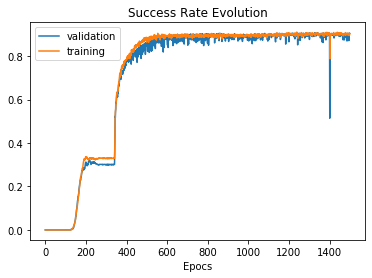

In [15]:
plt.plot(history_LSTM.epoch,history_LSTM.history['val_porcentaje_margen'],label='validation')
plt.plot(history_LSTM.epoch,history_LSTM.history['porcentaje_margen'],label="training")
plt.legend()
plt.title('Success Rate Evolution')
plt.xlabel('Epocs')
plt.show()

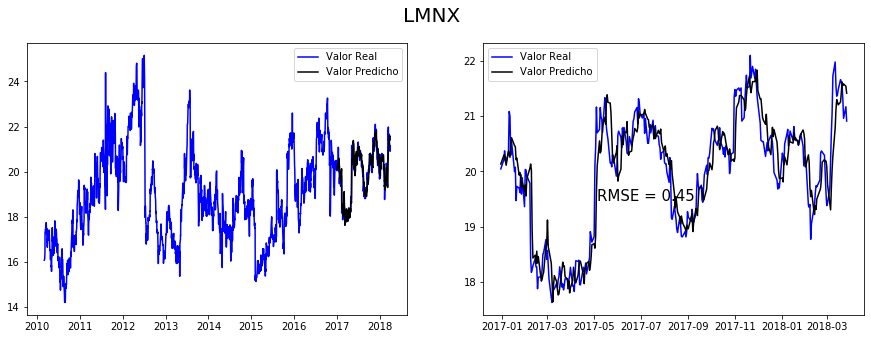

In [16]:
# Calculo la prediccion para mi conjunto test
predicted_stock_price = pd.DataFrame(model.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmse = sqrt(mean_squared_error(ytt, predicted_stock_price))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
fig.suptitle(tickers[index],fontsize = 20)
# Plot de todo el grafico
ax1.plot(indicedetiempo,stock_real_value,label="Valor Real",color = "blue")
ax1.plot(index_time_t,predicted_stock_price, label="Valor Predicho", color = "black")
ax1.legend()

# Plot de solo la parte que hemos hecho el predict
ax2.plot(index_time_t,ytt,label="Valor Real",color = "blue")
ax2.plot(index_time_t,predicted_stock_price, label="Valor Predicho", color = "black")
ax2.legend()
ax2.annotate('RMSE = %.2f'% rmse, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

plt.show()

Queremos realizar una inversion de 100000 euros en el activo que hemos estudiado, nos basamos en un margen entre la diferencia de los dos precios adyacentes para saber si comprar, vender o mantener.
Tenemos 3 posibles caminos, comprar solo a la alza, comprar solo a la baja o comprar a la alza y a la baja.
Ciertos actios tienen caidas o subidas muy bruscas imposibles de predecir porque no tienen que ver con los datos historicos si no con la situacion y el contexto que vive la empresa

In [25]:
pd.options.display.max_rows = 10000 # Para poder ver todos los movimientos

# Es un margen movil, segun lo que busquemos
margen = 0.00
diferencias = np.zeros(len(predicted_stock_price)-1)
for i in range(len(diferencias)):
    diferencias[i] = (predicted_stock_price.iloc[i+1,0]-predicted_stock_price.iloc[i,0])/max(predicted_stock_price.iloc[i+1,0],predicted_stock_price.iloc[i,0])
    if diferencias[i] > margen:
        diferencias[i] = 1
    elif diferencias[i] < -margen:
        diferencias[i] = -1
    else:
        diferencias[i] = 0
    
print(Counter(diferencias))

Counter({1.0: 165, -1.0: 144})


In [26]:
# Si solo queremos comrpar a la alza
# Estado es lo que hay que hacer ese dia
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_alza = pd.DataFrame(columns = ["presupuesto","acciones","estado","valor","pred","dif"],index = index_time_t)
movimientos_alza.presupuesto[0] = 100000 ; movimientos_alza.acciones[0] = 0 ; movimientos_alza.estado[0] = 0
movimientos_alza.valor[0] = ytt.iloc[0,0] ; movimientos_alza.pred[0] = predicted_stock_price.iloc[0,0]

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_alza.acciones[i-1] == 0:
            movimientos_alza.estado[i] = 1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] % ytt.iloc[i,0]
            movimientos_alza.acciones[i] = movimientos_alza.presupuesto[i-1] // ytt.iloc[i,0]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_alza.acciones[i-1] > 0:
            movimientos_alza.estado[i] = -1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] + movimientos_alza.acciones[i-1] * ytt.iloc[i,0]
            movimientos_alza.acciones[i] = 0
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]

            
movimientos_alza = movimientos_alza.drop(movimientos_alza.tail(1).index)
print(movimientos_alza.tail(1))
valor_f_alza = movimientos_alza.presupuesto[len(movimientos_alza)-1] + movimientos_alza.valor[len(movimientos_alza)-1] * movimientos_alza.acciones[len(movimientos_alza)-1]
ganancia_alza = valor_f_alza - 100000
print('Valor Final = %.2f' % valor_f_alza)
print('Ganancia con margen = %.2f' % ganancia_alza)

           presupuesto acciones estado  valor     pred dif
2018-03-26      104250        0      0  21.17  21.5417  -1
Valor Final = 104249.67
Ganancia con margen = 4249.67


In [19]:
print(movimientos_alza)

           presupuesto acciones estado    valor     pred  dif
2016-12-30      100000        0      0   20.044  20.1318  NaN
2017-01-03      100000        0      0  20.2124  20.2899    0
2017-01-04      100000        0      0   20.371  20.3034    0
2017-01-05      100000        0      0  20.1827  20.2005    0
2017-01-06      100000        0      0  20.1728    20.11    0
2017-01-09      100000        0      0  20.3512  20.3616    0
2017-01-10      100000        0      0  21.0844  20.3085    0
2017-01-11      100000        0      0  20.9952  20.2538    0
2017-01-12      100000        0      0  20.2917  20.5418    0
2017-01-13      100000        0      0  20.5493  20.6095    0
2017-01-17      100000        0      0  19.9945  20.4652    0
2017-01-18      100000        0      0  20.0737  20.4477    0
2017-01-19      100000        0      0  19.4693  20.2109    0
2017-01-20      100000        0      0  19.7269  20.2375    0
2017-01-23      100000        0      0  19.6972  19.9328    0
2017-01-

In [27]:
# Compro a la alza y a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_ab= pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_ab.presupuesto[0] = 100000 % ytt.iloc[0,0] ; movimientos_ab.acciones[0] = 100000 // ytt.iloc[0,0] ; movimientos_ab.acciones_debo[0] = 0 ;
movimientos_ab.estado[0] = 0 ; movimientos_ab.valor[0] = ytt.iloc[0,0] ;
movimientos_ab.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_ab.acciones[i-1] == 0:
            movimientos_ab.estado[i] = 1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         % ytt.iloc[i,0])
            movimientos_ab.acciones[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         // ytt.iloc[i,0])
            movimientos_ab.acciones_debo[i] = 0
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_ab.acciones_debo[i-1] == 0:
            movimientos_ab.estado[i] = -1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) +
                                          ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_ab.acciones[i] = 0
            movimientos_ab.acciones_debo[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) # Las pido prestadas
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
            
movimientos_ab = movimientos_ab.drop(movimientos_ab.tail(1).index)
print(movimientos_ab.tail(1))
if movimientos_ab.acciones_debo[len(movimientos_ab)-1] == 0 :
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] + movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones[len(movimientos_ab)-1]
else:
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] - movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones_debo[len(movimientos_ab)-1]
ganancia_ab = valor_f_ab - 100000
print('Valor Final = %.2f' % valor_f_ab)
print('Ganancia con margen = %.2f' % ganancia_ab)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      206139        0          4917      0  21.17  21.5417  -1
Valor Final = 102046.12
Ganancia con margen = 2046.12


In [ ]:
print(movimientos_ab)

In [28]:
# Compro a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_baja = pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_baja.presupuesto[0] = 100000  ; movimientos_baja.acciones[0] = 0 ; movimientos_baja.acciones_debo[0] = 0 ;
movimientos_baja.estado[0] = 0 ; movimientos_baja.valor[0] = ytt.iloc[0,0] ;
movimientos_baja.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_baja.acciones[i-1] == 0:
            movimientos_baja.estado[i] = 1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1] - (movimientos_baja.acciones_debo[i-1] * ytt.iloc[i,0])))
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = 0
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_baja.acciones_debo[i-1] == 0:
            movimientos_baja.estado[i] = -1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1]) + (movimientos_baja.presupuesto[i-1] //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = (movimientos_baja.presupuesto[i-1] // ytt.iloc[i,0]) # Las pido prestadas
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
            
movimientos_baja = movimientos_baja.drop(movimientos_baja.tail(1).index)
print(movimientos_baja.tail(1))
if movimientos_baja.acciones_debo[len(movimientos_baja)-1] == 0 :
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] + movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones[len(movimientos_baja)-1]
else:
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] - movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
ganancia_baja = valor_f_baja - 100000
print('Valor Final = %.2f' % valor_f_baja)
print('Ganancia con margen = %.2f' % ganancia_baja)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      196102        0          4678      0  21.17  21.5417  -1
Valor Final = 97069.08
Ganancia con margen = -2930.92


In [ ]:
print(movimientos_baja)